In [218]:
import gpflow
import numpy as np
import pandas as pd
import tensorflow as tf
from gpflow.base import _cast_to_dtype
from models.test_functions import TestFunLinearCorrelation
from gpflow.utilities import to_default_float, print_summary
from gpflow.config import default_float
# from gpflow.ci_utils import ci_niter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from utils.utils import build_models, train_models, get_final_models_dict, get_gridpoints, get_nlpd, get_abs_error
from models.lvmogp import LVMOGP


# Comparing multi-output Gaussian process  to the LMC

In this notebook I compare a multioutput GPR model to the LMC. The multioutput model (called the individual or indi
model here) has the same hyperparameters for all surfaces, but treats the data for all the surfaces seperately.

The LMC is the linear model of coregionalisation.

The test functions used here are uncorrelated draws from a GP, so the functions can be thought of as unrelated.

In this notebook I look to answer the questions:
- [How does the LMC perform compared to the indi model?](#part1)
- [What happens if we set $\kappa$ to be untrainable?](#part2)
- [How can we make the LMC perform the same as the indi model?](#part3)



## Create the Test functions

In [219]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

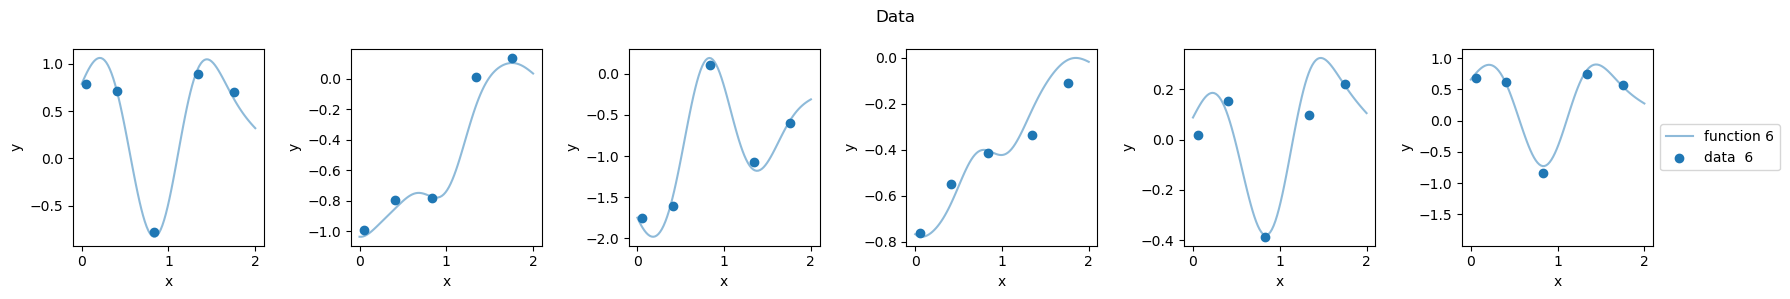

In [220]:
same_points = True
plot_figs = True

train_inducing = True
opt_seed = 3
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
n_fun = 6
n_points = 5
max_points = 5
noise = 0.1
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]


# Create the Test functions


test_fun = TestFunLinearCorrelation(domain, seed, n_fun, observed_dims, latent_dims, max_points, noise, n_grid_points,
                                    same_points, lengthscales_x)

data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)

if plot_figs:
    test_fun.plot_data_seperate_plots()


[Back to top](#Index:)

<a id='part1'></a>

## How does the LMC perform compared to the indi model?

First of all we fit an individual and a LMC model and look at the log marginal likelihood (LML) and the hyperparameters
to compare the models.

In this case where the test functions are unrelated, we would expect the LMC to perform the same as the individual model,
perhaps converging to the same model under the right circumstances.

In [221]:
continuous_dims = ['x1', 'x2'][:observed_dims]

Fit the individual model first

In [222]:
lengthscales_X = [0.1, 0.1][:len(continuous_dims)]


kernel_indi = gpflow.kernels.RBF(lengthscales=lengthscales_X)

indi_gp = gpflow.models.GPR(data=(tf.convert_to_tensor(test_fun.xs[0],  dtype=default_float()),
                             tf.convert_to_tensor(np.array(test_fun.ys).squeeze().T,  dtype=default_float())), kernel=kernel_indi)

print(test_fun.xs[0].shape)
print(np.hstack(test_fun.ys).shape)

(5, 1)
(5, 6)


optimise the individual model

In [223]:
maxiter = 2000

indi_opt = gpflow.optimizers.Scipy().minimize(
    indi_gp.training_loss, indi_gp.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

Make predictions and plot

In [224]:
x_new, fun_nos_new, x_lmc, x_new_lvmogp = get_gridpoints(domain, n_fun, {'mo_indi':indi_gp}, observed_dims, n_points=100)
indi_mu, indi_sig2 = indi_gp.predict_y(x_new)

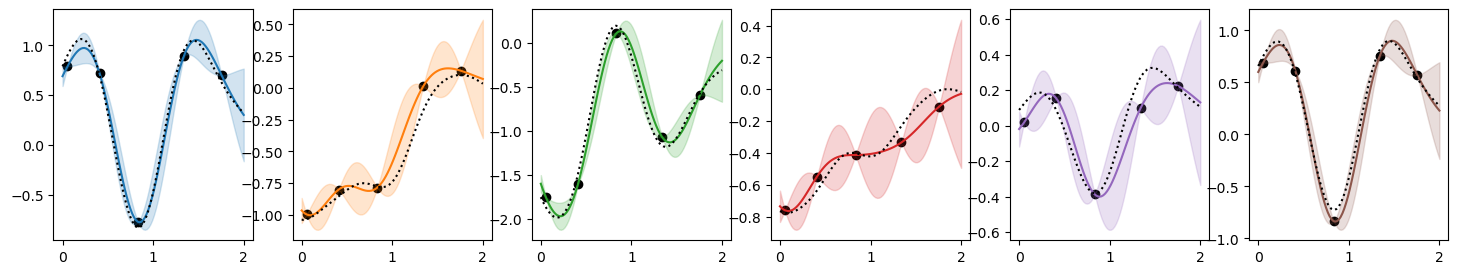

In [225]:
ys_new = []
fs_new = []
for fun in test_fun.functions:
    f_new, _ = fun.predict_y(x_new.reshape(100, 1))
    y_new = test_fun.function_with_noise(fun, x_new.reshape(100, 1), test_fun.noise)
    ys_new.append(y_new)
    fs_new.append(f_new)


if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        ax[i].plot(x_new, indi_mu[:, i], color=colors[i])
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k')
        ax[i].plot(x_new, fs_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), indi_mu[:, i].numpy().flatten() + np.sqrt(indi_sig2[:, i].numpy().flatten()),
                           indi_mu[:, i].numpy().flatten() - np.sqrt(indi_sig2[:, i].numpy().flatten()), alpha=0.2, color=colors[i])

Next do the same for the LMC model

In [226]:
lengthscales = lengthscales_X
X = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims,
                                              active_dims=[observed_dims])
cov = k * coreg_k
lmc = gpflow.models.GPR(data=(tf.convert_to_tensor(X, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)

In [227]:
maxiter = 2000

lmc_opt = gpflow.optimizers.Scipy().minimize(
    lmc.training_loss, lmc.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [228]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_mu, lmc_sig2 = lmc.predict_y(x_new_lmc)

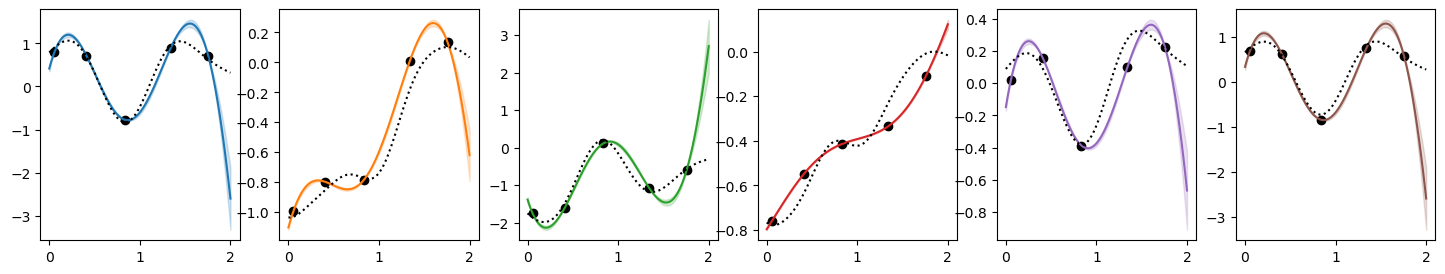

In [229]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k')
        ax[i].plot(x_new, fs_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_mu.numpy()[idx].flatten() + np.sqrt(lmc_sig2.numpy()[idx].flatten()),
                           lmc_mu.numpy()[idx].flatten() - np.sqrt(lmc_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])

print the W and kappa hyperparameters of the LMC.

When the functions are unrelated we expect the W to go very small as there is no relationship between the functions, so
there should be no correlation.

In this case the W doesn't go especially small and the kappas are all different.

In [230]:
print('W', lmc.kernel.kernels[1].W.numpy())
print('kappa',lmc.kernel.kernels[1].kappa.numpy())

W [[-300.15000872 -300.15000872]
 [ -71.74529042  -71.74529042]
 [ 290.45622862  290.45622862]
 [   3.79134797    3.79134797]
 [-100.62986163 -100.62986163]
 [-287.9059871  -287.9059871 ]]
kappa [5.39030267e-81 6.01611344e+01 4.27069989e+01 1.07693071e+02
 1.44595432e+02 5.81756977e-01]


Compare the log marginal likelihood and hyperparameters of the indi and LMC models.
Interestingly the lml of the lmc is higher than that of the individual. I have a hyppthesis that this might be because
the LMC is essentially letting the variance of each function be different, rather than making them all the same. This
explains why the kappas above are all different.

In [231]:
print('log marginal likelihood')
print('indi', indi_gp.log_marginal_likelihood())
print('lmc', lmc.log_marginal_likelihood())

log marginal likelihood
indi tf.Tensor(-29.733174288021324, shape=(), dtype=float64)
lmc tf.Tensor(5.48815600031304, shape=(), dtype=float64)


In [232]:
print('indi')
print_summary(indi_gp)
print('lmc')
print_summary(lmc)

indi
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.48757  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.2985] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0      │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═

<a id='part2'></a>
## What happens if we set $\kappa$ to be 0 and untrainable?

In [233]:
lengthscales = lengthscales_X
X = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims,
                                              active_dims=[observed_dims])
cov = k * coreg_k
lmc_nok = gpflow.models.GPR(data=(tf.convert_to_tensor(X, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)

# assign values to kappa
lmc_nok.kernel.kernels[1].kappa.assign(np.array([1e-6]*n_fun))
gpflow.set_trainable(lmc_nok.kernel.kernels[1].kappa, False)

In [234]:
maxiter = 2000

lmc_nok_opt = gpflow.optimizers.Scipy().minimize(
    lmc_nok.training_loss, lmc_nok.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [235]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc_nok = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_nok_mu, lmc_nok_sig2 = lmc_nok.predict_f(x_new_lmc)

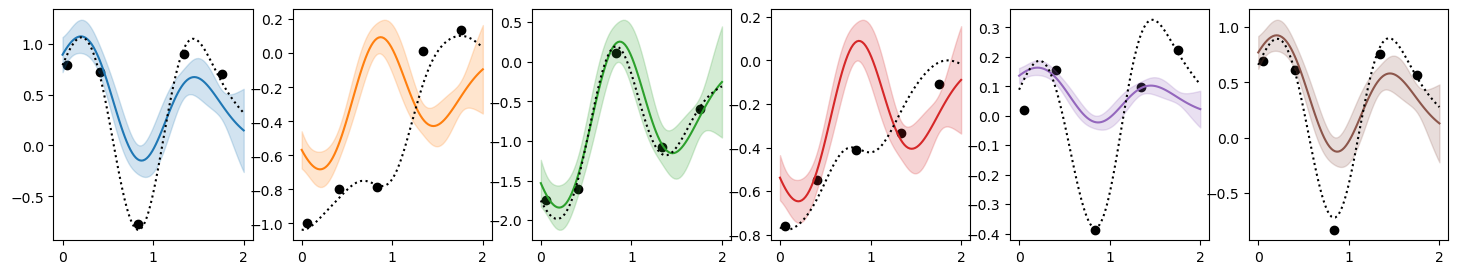

In [236]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_nok_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k')
        ax[i].plot(x_new, fs_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_nok_mu.numpy()[idx].flatten() + np.sqrt(lmc_nok_sig2.numpy()[idx].flatten()),
                           lmc_nok_mu.numpy()[idx].flatten() - np.sqrt(lmc_nok_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])

Print the log marginal likelihoods and hyperparameters again

In [237]:

print('log marginal likelihood')
print('indi', indi_gp.log_marginal_likelihood())
print('lmc', lmc.log_marginal_likelihood())
print('lmc_nok', lmc_nok.log_marginal_likelihood())

log marginal likelihood
indi tf.Tensor(-29.733174288021324, shape=(), dtype=float64)
lmc tf.Tensor(5.48815600031304, shape=(), dtype=float64)
lmc_nok tf.Tensor(-17.951885170579736, shape=(), dtype=float64)


In [238]:
print('indi')
print_summary(indi_gp)
print('lmc')
print_summary(lmc)
print('lmc_nok')
print_summary(lmc_nok)
print('lmc_noW')

indi
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.48757  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.2985] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0      │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═

<a id='part3'></a>
## How can we make the LMC perform the same as the indi model?

To make the LMC perform the same as the individual model we need to:

1) set W to be **0** and

2) set $\kappa$ = **1** .

Just setting W to be **0** isn't enough to make the LMC behave exactly like the individual. In that case the LML of the
LMC ends up somewhere between that of the individual and that of the LMC with no constraints on W or $\kappa$.


In [239]:

lengthscales = lengthscales_X
X = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims,
                                              active_dims=[observed_dims])
cov = k * coreg_k

lmc_noW = gpflow.models.GPR(data=(tf.convert_to_tensor(X, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)
lmc_noW.kernel.kernels[1].W.assign(np.ones((n_fun, 2)) * 1e-6)
gpflow.set_trainable(lmc_noW.kernel.kernels[1].W, False)
lmc_noW.kernel.kernels[1].kappa.assign(np.array([1]*n_fun))
gpflow.set_trainable(lmc_noW.kernel.kernels[1].kappa, False)

In [240]:
maxiter = 2000
lmc_noW_opt = gpflow.optimizers.Scipy().minimize(
    lmc_noW.training_loss, lmc_noW.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [241]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc_noW = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_noW_mu, lmc_noW_sig2 = lmc_noW.predict_f(x_new_lmc)

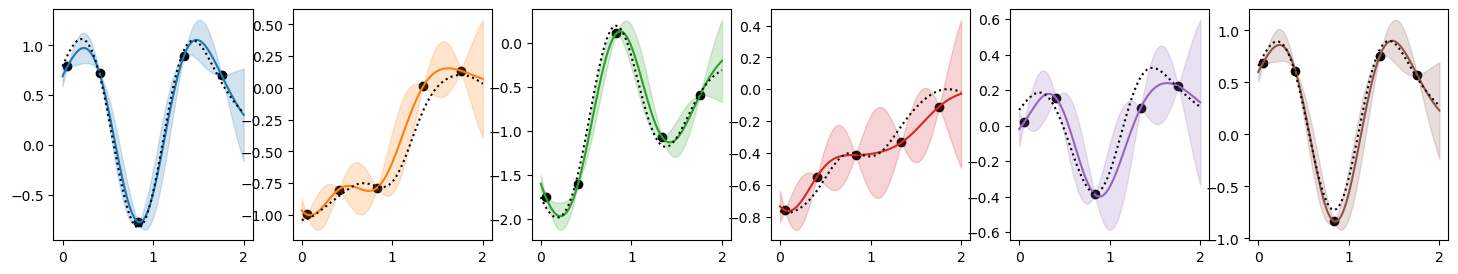

In [242]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_noW_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k')
        ax[i].plot(x_new, fs_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_noW_mu.numpy()[idx].flatten() + np.sqrt(lmc_noW_sig2.numpy()[idx].flatten()),
                           lmc_noW_mu.numpy()[idx].flatten() - np.sqrt(lmc_noW_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])


Print the log marginal likelihoods. You can see from below the LMC with W=1 and kappa=0 has the same LML as the individual
model and the same hyperparameters, meaning we are recovering the same model.

In [243]:
print('log marginal likelihood')
print('indi', indi_gp.log_marginal_likelihood())
print('lmc', lmc.log_marginal_likelihood())
print('lmc kappa = 0', lmc_nok.log_marginal_likelihood())
print('lmc W = 0, kappa = 1', lmc_noW.log_marginal_likelihood())

log marginal likelihood
indi tf.Tensor(-29.733174288021324, shape=(), dtype=float64)
lmc tf.Tensor(5.48815600031304, shape=(), dtype=float64)
lmc kappa = 0 tf.Tensor(-17.951885170579736, shape=(), dtype=float64)
lmc W = 0, kappa = 1 tf.Tensor(-29.73317428801988, shape=(), dtype=float64)


In [244]:
print('indi')
print_summary(indi_gp)
print('lmc')
print_summary(lmc)
print('lmc_nok')
print_summary(lmc_nok)
print('lmc_noW')
print_summary(lmc_noW)


indi
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.48757  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.2985] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0      │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═

the log marginal likelihood and the hyperparameters of all the models. The lml of the model with W=0 and same value
for kappa for all functions is that same as that for the indi model. The hyperparameters are also almost the same (if we
multiple the kappa and the kernel variance in the lmc as they are doing the same thing here) showing we are recovering
 the same model.

The lengthscale and likelihood variance of the setting kappa model has recovered that of the individual model. The
kernel variance looks different but if we multiply the kernel variance by kappa we recover the kernel variance of the
individual model.
